# Part 4 — NLP: Sentiment Analysis for the Travel & Hostel Industry

Welcome to Part 4 of the course! In this hands-on notebook we’ll build a sentiment analysis workflow tailored to **travel and hostel** text data (reviews, chats, social posts).

You’ll learn to:
1. Use **VADER** (Valence Aware Dictionary and sEntiment Reasoner) for informal travel text.
2. Score individual sentences and full datasets.
3. Convert scores into **labels** (positive / neutral / negative) with sensible thresholds.
4. Aggregate results by **property/hostel** and **channel** (e.g., Booking, Hostel, X/Twitter).
5. Visualize sentiment distribution and property-level KPIs.
6. Handle emojis, negation, and domain terms common in travel.

> **Why VADER?** It’s rules-based and **works directly on raw text** (punctuation, casing, emojis all matter). That makes it great for social media and short, informal reviews where **word order, punctuation, and emojis** carry sentiment signal.


## 0) Setup
Install dependencies and import libraries.

In [ ]:
!pip -q install vaderSentiment pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pd.set_option('display.max_colwidth', None)
print('Setup complete.')

Setup complete.


## 1) Sample Travel/Hostel Dataset
We’ll start with a small, realistic dataset. You can replace this later with your own CSV.

**Columns**
- `date`: date string (YYYY-MM-DD)
- `property_name`: hostel name
- `channel`: where the text came from
- `text`: the raw text we’ll analyze (keep emojis & punctuation!)

In [ ]:
data = [
    {
        'date': '2025-07-12',
        'property_name': 'Sunny Steps Hostel',
        'channel': 'Hostelworld',
        'text': "Loved the rooftop vibes and friendly staff 😍 The dorms were spotless and the pub crawl was a blast!"
    },
    {
        'date': '2025-07-13',
        'property_name': 'Sunny Steps Hostel',
        'channel': 'Google Reviews',
        'text': "Location is great but I didn't like the noisy AC at night. Breakfast was okay."
    },
    {
        'date': '2025-07-14',
        'property_name': 'Porto Pals Hostel',
        'channel': 'X/Twitter',
        'text': "PORTO PALS IS AMAZING!!! Best walking tour ever, met so many cool travelers 🔥🔥"
    },
    {
        'date': '2025-07-15',
        'property_name': 'Porto Pals Hostel',
        'channel': 'Instagram',
        'text': "The staff *said* check-in was 24/7, but we waited 40 mins at 2am… not cool :/"
    },
    {
        'date': '2025-07-16',
        'property_name': 'Riverside Bunks',
        'channel': 'Booking',
        'text': "Unfortunately, the showers were cold and the lockers didn't work. Would not return."
    },
    {
        'date': '2025-07-17',
        'property_name': 'Riverside Bunks',
        'channel': 'TripAdvisor',
        'text': "Great value for money. Clean kitchen and comfy beds. The view over the river is lovely :)"
    },
]

df = pd.DataFrame(data)
df

,date,property_name,channel,text
0,2025-07-12,Sunny Steps Hostel,Hostelworld,Loved the rooftop vibes and friendly staff 😍 The dorms were spotless and the pub crawl was a blast!
1,2025-07-13,Sunny Steps Hostel,Google Reviews,Location is great but I didn't like the noisy AC at night. Breakfast was okay.
2,2025-07-14,Porto Pals Hostel,X/Twitter,"PORTO PALS IS AMAZING!!! Best walking tour ever, met so many cool travelers 🔥🔥"
3,2025-07-15,Porto Pals Hostel,Instagram,"The staff *said* check-in was 24/7, but we waited 40 mins at 2am… not cool :/"
4,2025-07-16,Riverside Bunks,Booking,"Unfortunately, the showers were cold and the lockers didn't work. Would not return."
5,2025-07-17,Riverside Bunks,TripAdvisor,Great value for money. Clean kitchen and comfy beds. The view over the river is lovely :)


## 2) Quick VADER Primer
VADER returns a dict with four keys:
- `neg`, `neu`, `pos`: proportions of negative/neutral/positive signal
- `compound`: the overall sentiment in **[-1, +1]** (most important)

Typical labeling thresholds (from VADER authors):
- `compound >= 0.05` → **positive**
- `compound <= -0.05` → **negative**
- otherwise → **neutral**

These thresholds are good defaults, but feel free to tweak for your domain/use-case.

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sample = df.loc[0, 'text']
scores = analyzer.polarity_scores(sample)
sample, scores

('Loved the rooftop vibes and friendly staff 😍 The dorms were spotless and the pub crawl was a blast!',
 {'neg': 0.0, 'neu': 0.646, 'pos': 0.354, 'compound': 0.8858})

## 3) Helper Functions
We’ll write clear utility functions so you can re-use them in production notebooks.

In [ ]:
def get_compound(text: str, _analyzer=None) -> float:
    """Return VADER compound score for a given text.
    Keeps raw text so emojis, punctuation, caps, and negation influence the score.
    """
    a = _analyzer or analyzer
    return a.polarity_scores(str(text))['compound']

def label_from_compound(c: float) -> str:
    """Map compound score to a label using VADER defaults.
    Adjust thresholds for your use-case if needed.
    """
    if c >= 0.05:
        return 'positive'
    if c <= -0.05:
        return 'negative'
    return 'neutral'

## 4) Apply to the Dataset
We compute compound scores and labels for each review.

In [ ]:
df['compound'] = df['text'].apply(get_compound)
df['sentiment'] = df['compound'].apply(label_from_compound)
df

,date,property_name,channel,text,compound,sentiment
0,2025-07-12,Sunny Steps Hostel,Hostelworld,Loved the rooftop vibes and friendly staff 😍 The dorms were spotless and the pub crawl was a blast!,0.8858,positive
1,2025-07-13,Sunny Steps Hostel,Google Reviews,Location is great but I didn't like the noisy AC at night. Breakfast was okay.,0.4610,positive
2,2025-07-14,Porto Pals Hostel,X/Twitter,"PORTO PALS IS AMAZING!!! Best walking tour ever, met so many cool travelers 🔥🔥",0.8551,positive
3,2025-07-15,Porto Pals Hostel,Instagram,"The staff *said* check-in was 24/7, but we waited 40 mins at 2am… not cool :/",0.0286,neutral
4,2025-07-16,Riverside Bunks,Booking,"Unfortunately, the showers were cold and the lockers didn't work. Would not return.",-0.3400,negative
5,2025-07-17,Riverside Bunks,TripAdvisor,Great value for money. Clean kitchen and comfy beds. The view over the river is lovely :),0.9432,positive


## 5) Aggregation: Property & Channel KPIs
Let’s compute KPIs by property and channel: average compound and label distribution.

In [ ]:
# Average compound by property
kpi_property = df.groupby('property_name')['compound'].mean().reset_index().sort_values('compound', ascending=False)
kpi_property

,property_name,compound
2,Sunny Steps Hostel,0.67340
0,Porto Pals Hostel,0.44185
1,Riverside Bunks,0.30160


In [ ]:
# Label distribution by property
dist_property = (
    df.groupby(['property_name', 'sentiment'])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)
dist_property

sentiment,property_name,negative,neutral,positive
0,Porto Pals Hostel,0,1,1
1,Riverside Bunks,1,0,1
2,Sunny Steps Hostel,0,0,2


In [ ]:
# Average compound by channel
kpi_channel = df.groupby('channel')['compound'].mean().reset_index().sort_values('compound', ascending=False)
kpi_channel

,channel,compound
4,TripAdvisor,0.9432
2,Hostelworld,0.8858
5,X/Twitter,0.8551
1,Google Reviews,0.4610
3,Instagram,0.0286
0,Booking,-0.3400


## 6) Visualizations
Use simple matplotlib charts. (One chart per cell; no seaborn; no custom colors.)

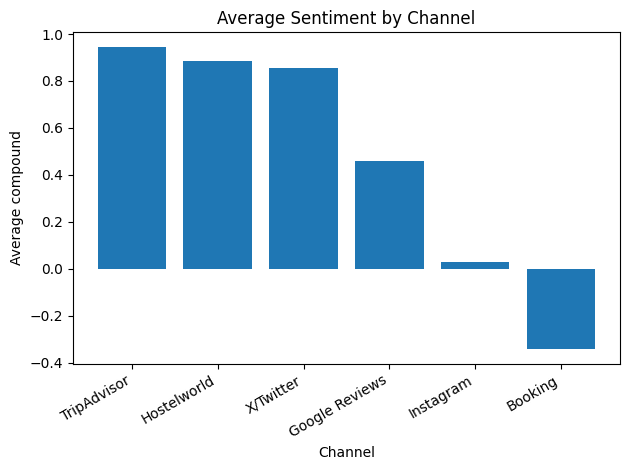

In [ ]:
# Average compound by channel (bar chart)
plt.figure()
plt.bar(kpi_channel['channel'], kpi_channel['compound'])
plt.title('Average Sentiment by Channel')
plt.xlabel('Channel')
plt.ylabel('Average compound')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

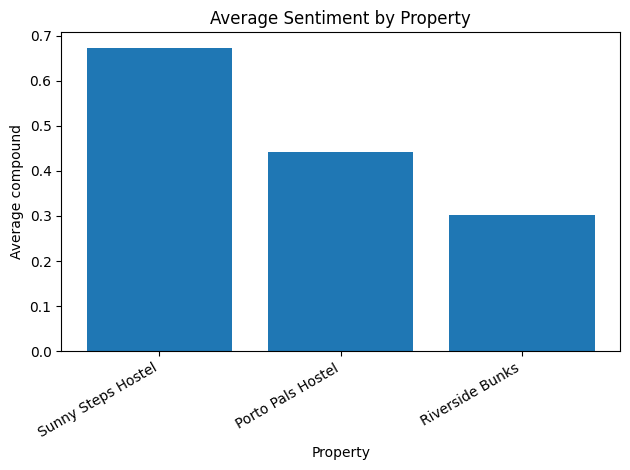

In [ ]:
# Average compound by property (bar chart)
plt.figure()
plt.bar(kpi_property['property_name'], kpi_property['compound'])
plt.title('Average Sentiment by Property')
plt.xlabel('Property')
plt.ylabel('Average compound')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

## 7) Negation, Emojis, and Emphasis — Quick Checks
VADER reacts to negation (e.g., *didn't like*), emojis (e.g., 🙂🔥), and emphasis (ALL CAPS, exclamation!).
Let’s see examples relevant to travel.

In [ ]:
tests = [
    "I didn't like the bathroom but the staff were super kind.",
    "The bar crawl was LIT!!!",  # emphasis
    "Check-in was smooth and the vibe was chill 🙂",
    "The location is not bad.",  # faint praise
    "Beds were AMAZING but showers were cold :(",
]

for t in tests:
    print(t)
    print(analyzer.polarity_scores(t))
    print('-'*60)

I didn't like the bathroom but the staff were super kind.
{'neg': 0.08, 'neu': 0.41, 'pos': 0.51, 'compound': 0.8859}
------------------------------------------------------------
The bar crawl was LIT!!!
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
------------------------------------------------------------
Check-in was smooth and the vibe was chill 🙂
{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.4033}
------------------------------------------------------------
The location is not bad.
{'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'compound': 0.431}
------------------------------------------------------------
Beds were AMAZING but showers were cold :(
{'neg': 0.305, 'neu': 0.476, 'pos': 0.219, 'compound': -0.2694}
------------------------------------------------------------


## 8) Bring Your Own Data (CSV)
To run this on your own reviews, prepare a CSV with at least a `text` column. Optional columns: `date`, `property_name`, `channel`, `rating`.

```text
date,property_name,channel,text,rating
2025-08-01,Sunny Steps Hostel,Google Reviews,"Loved the staff and free sangria night!",5
2025-08-02,Porto Pals Hostel,Hostelworld,"Didn't sleep well, street noise.",2
```

Then run the cell below (adjust filename as needed).

In [ ]:
# Example: load your CSV
# uploaded_df = pd.read_csv('/content/your_reviews.csv')  # Google Colab path after upload
# uploaded_df['compound'] = uploaded_df['text'].apply(get_compound)
# uploaded_df['sentiment'] = uploaded_df['compound'].apply(label_from_compound)
# uploaded_df.head()

## 9) Tips for Production Use
- Keep **raw text** for VADER (don’t strip emojis, punctuation, casing).
- Tune label thresholds if your domain has skew (e.g., mostly positive reviews).
- For longer-form reviews, consider **sentence-level** scoring and take an aggregate (mean/median/max).
- Mix rules-based VADER with **ML classifiers** for domain-specific signals (e.g., cleanliness, Wi‑Fi, check-in).
- Track KPIs over time (weekly/monthly) to catch declines early.
- Always **manually spot-check** a sample (especially edge cases) to calibrate expectations.
